In [99]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [79]:
shipment_number = '001'
shipment_year = '2024'
product_list = pd.read_excel('PurchaseRequirement1.xlsx', engine = 'openpyxl')
column_name = next((col for col in product_list.columns if shipment_number in col and shipment_year in col and 'stock_before_' not in col), None)
product_list = product_list[product_list[column_name] != 0]
product_codes = product_list['itemcode'].tolist()

In [80]:
# Alternative method, take the sales of the first week of sales
# against the prices that were set (inflation adjusted) based on shipment information
# cannot get discount variations, which might push the demand down

# sales_data_w = pd.read_excel('PurchaseCohort1.xlsx', engine = 'openpyxl')
# sales_data_w = sales_data_w[['itemcode','itemname','combinedate','average sales price','1']]
# sales_data_w[['xyear', 'xper', '_']] = sales_data_w['combinedate'].str.split('-', expand=True)
# sales_data_w = sales_data_w[sales_data_w['itemcode'].isin(product_codes)]
# sales_data_w = sales_data_w.drop(columns=['combinedate','_'])
# sales_data_w['xyear'] = sales_data_w['xyear'].astype(int)
# sales_data_w['xper'] = sales_data_w['xper'].astype(int)
# sales_data_w = sales_data_w.rename(columns={'itemcode':'xitem','itemname':'xdesc','average sales price':'sales_price','1':'xqty'})


In [81]:
# Alternatively Directly from the database. 
db_config = {'user': 'XXXXXX','password': 'XXXXXX','host': 'XXXXXX','port': '5432', 'database': 'XXXXXX'}
engine = create_engine(f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")
query = f"""
    SELECT imtrn.xitem, caitem.xdesc,imtrn.xyear, imtrn.xper, imtrn.xqty, imtrn.xval, opddt.xlineamt, imtrn.xdocnum
    FROM imtrn 
    JOIN caitem
    ON imtrn.xitem = caitem.xitem
    JOIN opddt
    ON imtrn.xdocnum = opddt.xdornum AND imtrn.xitem = opddt.xcode
    WHERE imtrn.zid = 100001
    AND caitem.zid = 100001
    AND opddt.zid = 100001
    AND imtrn.xitem IN %(product_codes)s
    """
sales_data = pd.read_sql(query, con=engine, params={"product_codes": tuple(product_codes)})

In [85]:
# per invoice - graphically might not make sense
sales_data['sales_price'] = sales_data['xlineamt']/sales_data['xqty']
sales_data_i = sales_data
sales_data_i = sales_data_i.drop(columns=['xval','xlineamt'])

In [86]:
# per month
sales_data_m = sales_data.groupby(['xitem', 'xdesc', 'xyear', 'xper']).agg({
        'xqty': 'sum',
        'sales_price': 'mean'}).reset_index()
# sales_data_m = sales_data_m[sales_data_m['xyear'] >= 2022]

#adjust for inflation,
max_year = sales_data_m['xyear'].max()
inflation_rate = 0.07
sales_data_m['adjusted_price'] = sales_data_m.apply(
    lambda row: row['sales_price'] * (1 + inflation_rate) ** (max_year - row['xyear']),
    axis=1
)

In [94]:
# Calculate the average quantity for each product and adjust lower than a certain threshold to remove months where the product was not available and only returns where refurbished and sold. 
avg_qty_per_product = sales_data_m.groupby('xitem')['xqty'].transform('mean')
sales_data_m = sales_data_m[sales_data_m['xqty'] >= 0.7 * avg_qty_per_product]
sales_data_m = sales_data_m.sort_values(by=['xitem', 'xyear', 'xper']).reset_index(drop=True)

# Calculate elasticity 
sales_data_m['pct_change_sales'] = sales_data_m.groupby('xitem')['xqty'].pct_change()
sales_data_m['pct_change_price'] = sales_data_m.groupby('xitem')['adjusted_price'].pct_change()
sales_data_m['elasticity'] = sales_data_m['pct_change_sales'] / sales_data_m['pct_change_price']

# find how price and demand are correlated, no correlation if too little data points
def calculate_group_correlation(group):
    if len(group) > 1:
        correlation = group['adjusted_price'].corr(group['xqty'])
    else:
        correlation = None  
    group['correlation'] = correlation
    return group

sales_data_m = sales_data_m.groupby('xitem').filter(lambda x: len(x) > 1).groupby('xitem').apply(calculate_group_correlation)


In [109]:
# model fitting and comparison
def fit_and_evaluate_model(group):
    if len(group) >= 3:  
        X = group[['adjusted_price']]
        y = group['xqty']
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Linear Regression
        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train)
        y_pred_linear = linear_model.predict(X_test)

    
        mse_linear = mean_squared_error(y_test, y_pred_linear)
        r2_linear = r2_score(y_test, y_pred_linear)
        group['linear_mse'] = mse_linear
        group['linear_r2'] = r2_linear

        # Polynomial Regression
        poly = PolynomialFeatures(degree=2)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)

        poly_model = LinearRegression()
        poly_model.fit(X_poly_train, y_train)
        y_pred_poly = poly_model.predict(X_poly_test)


        mse_poly = mean_squared_error(y_test, y_pred_poly)
        r2_poly = r2_score(y_test, y_pred_poly)
        group['poly_mse'] = mse_poly
        group['poly_r2'] = r2_poly
        
        price_range = np.linspace(group['adjusted_price'].min(), group['adjusted_price'].max(), 100).reshape(-1, 1)

        # Predict sales using the best model
        if r2_linear > r2_poly:
            sales_pred = linear_model.predict(price_range)
        else:
            sales_pred = poly_model.predict(poly.fit_transform(price_range))


        max_sales_index = np.argmax(sales_pred)
        optimal_price = price_range[max_sales_index][0]


        group['optimal_price'] = optimal_price


        plt.plot(price_range, sales_pred)
        plt.xlabel('Price')
        plt.ylabel('Predicted Sales')
        plt.title(f'Price vs Predicted Sales for Product {group["xitem"].iloc[0]}')
        plt.show()
    else:
        # Not enough data to fit the model
        group['optimal_price'] = None
        group['linear_mse'] = None
        group['linear_r2'] = None
        group['poly_mse'] = None
        group['poly_r2'] = None
    return group


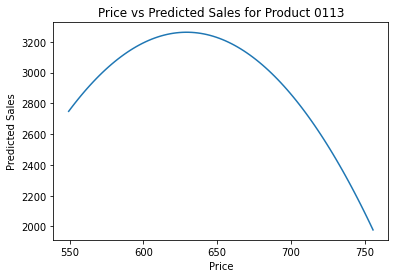

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


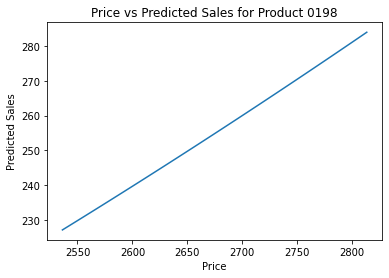

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


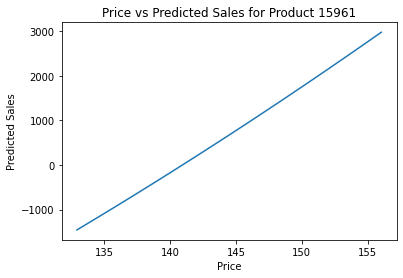

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


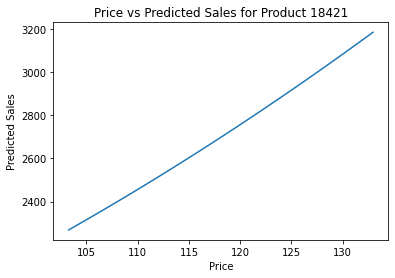

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


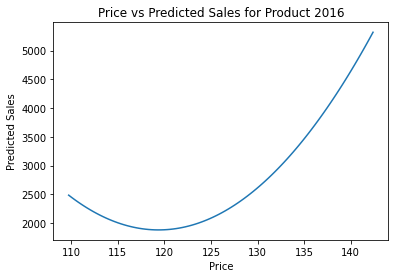

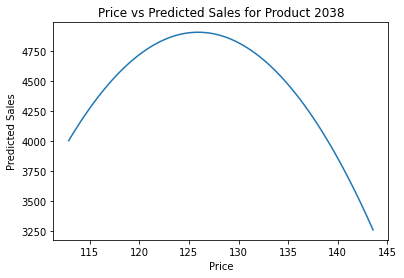

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


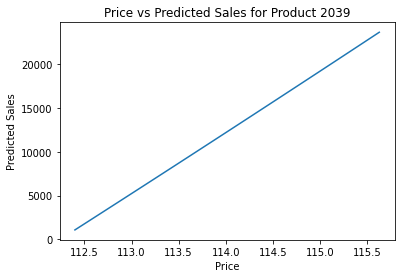

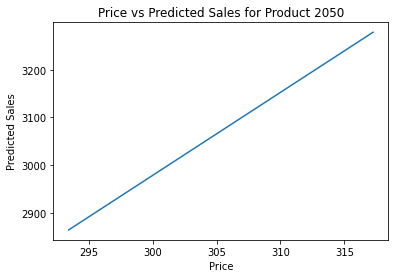

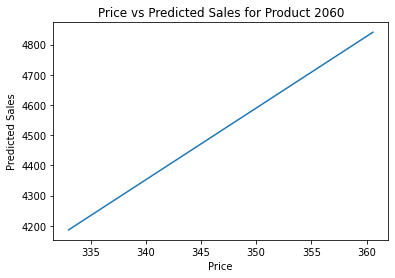

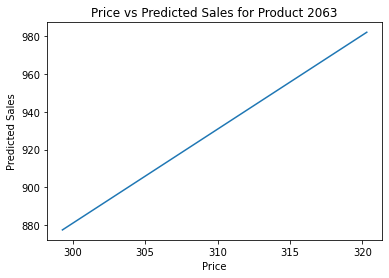

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


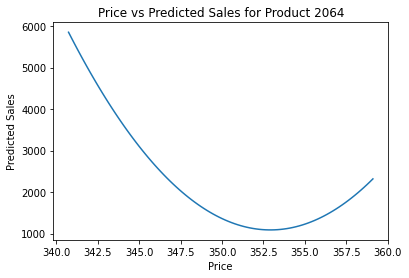

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


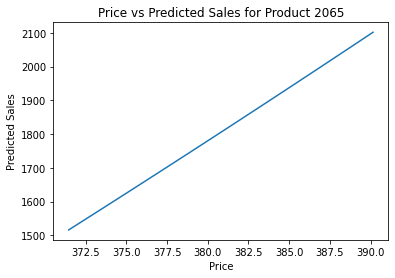

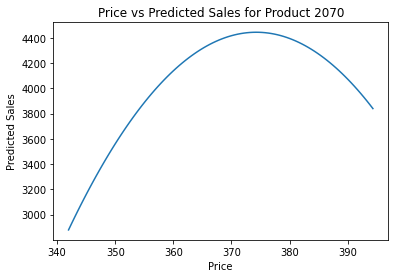

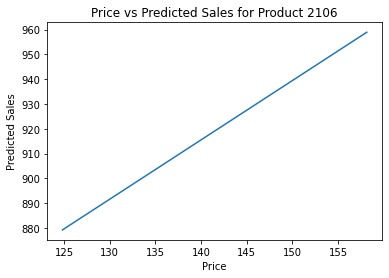

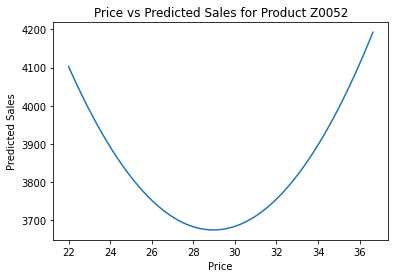

In [110]:
# Apply the function to each group
sales_data_m_filtered = sales_data_m.groupby('xitem').filter(lambda x: len(x) >= 3)
sales_data_m = sales_data_m_filtered.groupby('xitem').apply(fit_and_evaluate_model).reset_index(drop=True)

In [112]:
sales_data_m.to_excel('sales_data_analysis.xlsx')

In [ ]:
# future work - adjustment of inflation rate, adjustment of filter rate, find seasonality relations within data, 

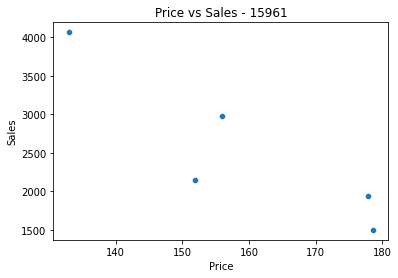

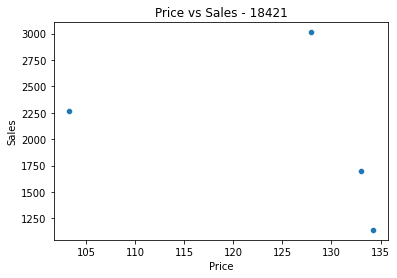

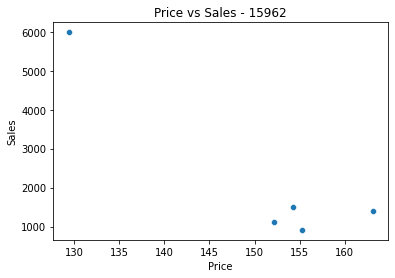

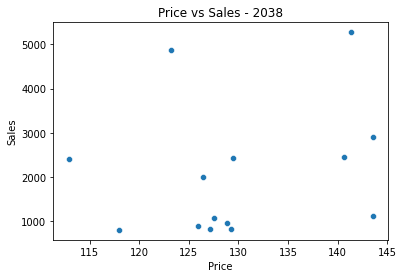

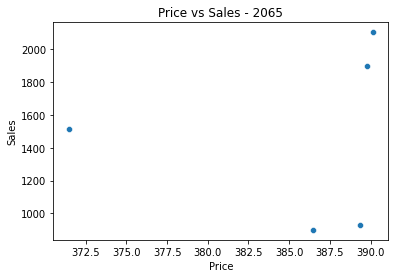

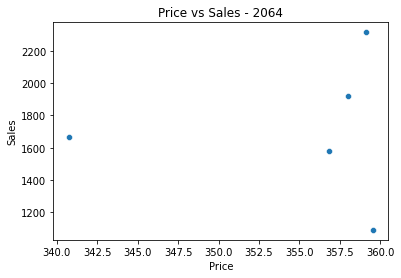

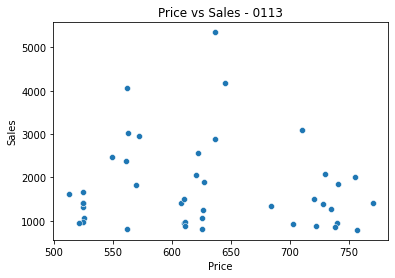

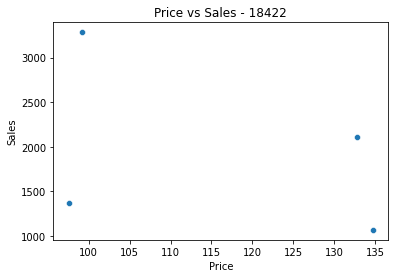

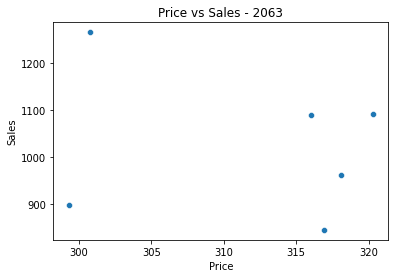

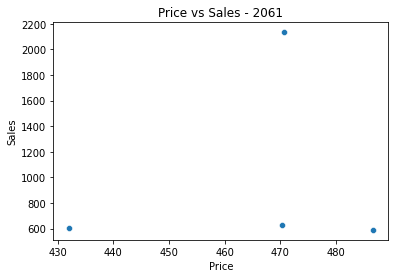

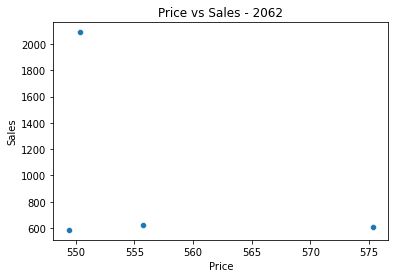

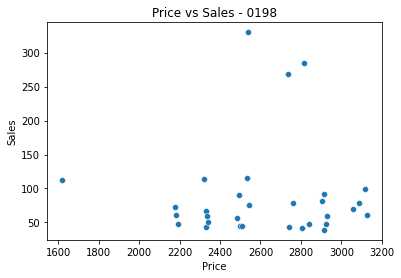

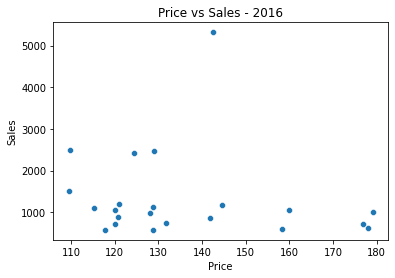

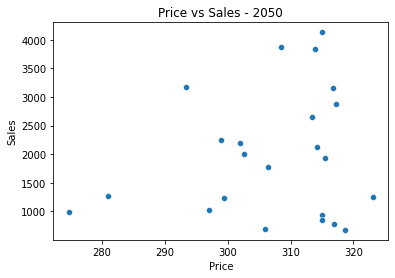

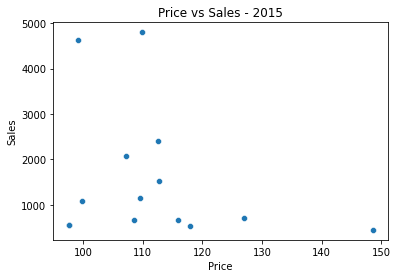

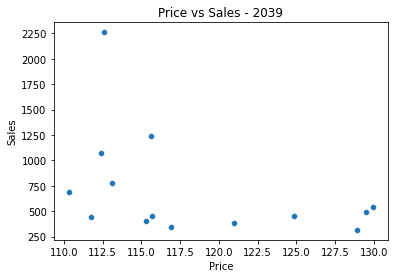

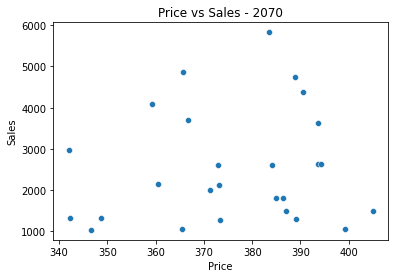

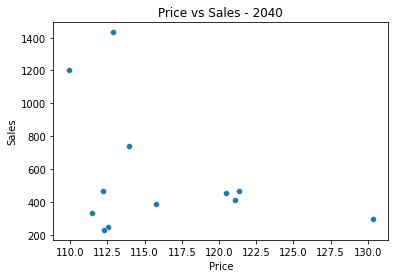

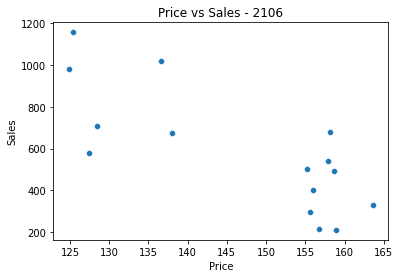

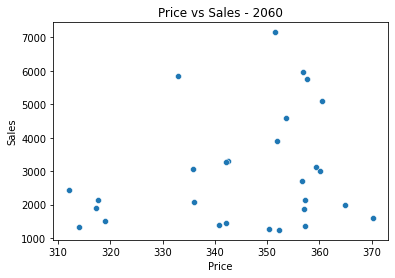

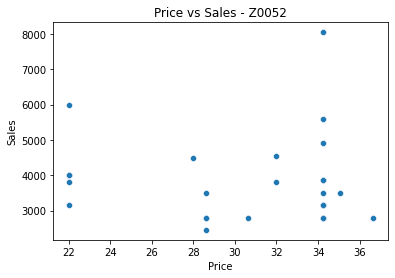

In [89]:
# scatterplot per month
for i in product_codes:
    data = sales_data_m[sales_data_m['xitem']==i]
    sns.scatterplot(x='adjusted_price', y='xqty', data=data)
    plt.xlabel('Price')
    plt.ylabel('Sales')
    plt.title(f'Price vs Sales - {i}')
    plt.show()